# NLP Analysis of Amazon Reviews Data

In [36]:
import numpy as np 
import pandas as pd
import json
import time
import re
import seaborn as sns
import random

from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

# Text cleaning
from nltk import sent_tokenize, word_tokenize, regexp_tokenize
from nltk.stem import WordNetLemmatizer
import spacy 
nlp = spacy.load('en_core_web_sm')
from nltk.corpus import stopwords

# Phrase Finder w Gensim
from nltk.tokenize import sent_tokenize
from gensim.models import Phrases
from gensim.utils import simple_preprocess
from gensim.models.phrases import ENGLISH_CONNECTOR_WORDS

# Topic Modeling 
from sklearn.decomposition import TruncatedSVD, NMF, LatentDirichletAllocation, LatentDirichletAllocation
from wordcloud import WordCloud

# Cosine Similarity 
from sklearn.metrics.pairwise import cosine_similarity

## Load saved reviews and metadata csv's

In [3]:
# reviews1M = pd.read_csv('../data/reviews_subset_1M.csv', index_col = False)
# metadata = pd.read_csv('../data/meta_subset_1M.csv', index_col = False)
merge_df = pd.read_csv('../data/merge_df.csv', low_memory = False, index_col = False)

In [4]:
# merge_df = merge_df.drop(columns = {'bought_together', 'subtitle', 'author'})
merge_df = merge_df.drop(columns = {'Unnamed: 0'})

In [5]:
merge_df.columns

Index(['rating', 'title', 'text', 'asin', 'parent_asin', 'user_id',
       'timestamp', 'helpful_vote', 'verified_purchase', 'year',
       'main_category', 'average_rating', 'rating_number', 'features',
       'description', 'price', 'images', 'videos', 'store', 'categories',
       'details', 'bought_together', 'subtitle', 'author'],
      dtype='object')

## Filtering the dataframe to a specific brand or product

In [6]:
print(f"Unique store count: {merge_df['parent_asin'].nunique()}")
print('-----------')
merge_df['store'].value_counts().head(15)

Unique store count: 245304
-----------


store
Coleman                   11886
Fitbit                     6790
CamelBak                   4898
Alvada                     4339
Franklin Sports            4142
BalanceFrom                3565
Amazon Basics              3517
WILSON                     3179
WinCraft                   3095
CAP Barbell                3026
Outdoorsman Lab            2971
FOCO                       2913
Schwinn                    2877
Contigo                    2867
Sunny Health & Fitness     2795
Name: count, dtype: int64

In [7]:
# Assigning a specific store name
store = 'Fitbit'

filtered_df = merge_df.loc[merge_df['store'] == store].reset_index()

In [8]:
filtered_df.columns

Index(['index', 'rating', 'title', 'text', 'asin', 'parent_asin', 'user_id',
       'timestamp', 'helpful_vote', 'verified_purchase', 'year',
       'main_category', 'average_rating', 'rating_number', 'features',
       'description', 'price', 'images', 'videos', 'store', 'categories',
       'details', 'bought_together', 'subtitle', 'author'],
      dtype='object')

In [9]:
def generate_brand_report(df, store):
    """
    Generates a report for a specified store, including counts of unique parent and product IDs, 
    and statistics on reviews and ratings.
    """
    # Filter the DataFrame by the specified store
    filtered_df = df[df['store'] == store]
    print(f"Store: {store}")
    print('-----')

    # Count number of reviews
    complete_reviews_count = filtered_df['rating_number'].unique().sum()
    print(f"Number of reviews in complete Amazon dataset: {complete_reviews_count}")
    print(f"Number of reviews in df: {len(filtered_df)}")  # Some customers only include a title and rating to their reviews
    
    # Calculate the number of unique parent_asin values
    parent_asin_count = filtered_df['parent_asin'].nunique()
    print(f"Count of unique parent product IDs: {parent_asin_count}")
    
    # Count the number of unique asin values
    asin_count = filtered_df['asin'].nunique()
    print(f"Count of unique product ID's: {asin_count}")
    
    # Calculate the number of reviews and average review rating for each asin
    asin_reviews_ratings = filtered_df.groupby('parent_asin').agg({'average_rating': 'mean', 'rating_number': 'mean'}).reset_index()
    
    # Find the top and bottom ten products with the best and worst rating
    top_ten_best = asin_reviews_ratings.nlargest(10, 'average_rating')
    bottom_ten_worst = asin_reviews_ratings.nsmallest(10, 'average_rating')
    print('-----')
    print(f"Top ten products: \n {top_ten_best}")
    print('-----')
    print(f"Bottom ten products: \n {bottom_ten_worst}")

# Apply function
generate_brand_report(filtered_df, store)

Store: Fitbit
-----
Number of reviews in complete Amazon dataset: 368687
Number of reviews in df: 6790
Count of unique parent product IDs: 73
Count of unique product ID's: 145
-----
Top ten products: 
    parent_asin  average_rating  rating_number
55  B07SW1RHRP             4.6        19841.0
60  B08GM3QY5N             4.5        17595.0
63  B08YMSB79F             4.5         7527.0
64  B092CMKSYY             4.5         5173.0
70  B0BGK9MYPV             4.5         5012.0
39  B01L6RE7Z4             4.4        17991.0
43  B06XFVKG6Y             4.4         4357.0
47  B072LV63PH             4.4        17526.0
51  B07MM5WMPF             4.4        17965.0
52  B07MQFPDSS             4.4        10802.0
-----
Bottom ten products: 
    parent_asin  average_rating  rating_number
49  B07653BH73             2.2            8.0
27  B0178WL1T6             2.7            8.0
30  B019NXMQCY             2.8           33.0
28  B017AGN7GK             3.2          223.0
25  B00VDGBNZ6             3.3   

In [10]:
def generate_random_examples(df, column, interest):
    """
    Generate three examples of random records with the specified interest. 
    
    Parameters: 
    df: DataFrame where the search will occur. 
    column: Column name to search within. 
    interest: Value to search for in the specified column. 
    """
    # Print average rating for parent_asin 
    interest_average_rating = df[df[column] == interest]['average_rating'].unique()
    print(f'Average rating: {interest_average_rating[0]}\n')
    print(f'Categories: {df[df[column] == interest]["categories"].iloc[0]}\n')
    print(f'Details: {df[df[column] == interest]["details"].iloc[0]}\n')
    
    # Filter the Datadf[df[column] == interest]Frame based on the interest
    filtered_df = df[df[column] == interest]

    # Set number of examples 
    num_of_ex = 3 
    
    # Check if there are enough records to sample
    if len(filtered_df) < num_of_ex:
        print(f"Not enough records found for interest '{interest}'. Found {len(filtered_df)} records.")
        return
    
    # Randomly select three records
    random_examples = filtered_df.sample(n=num_of_ex)
    
    for i, row in random_examples.iterrows():
        print('-----')
        print(f'Rating: {row["rating"]}\n')
        print(f'Title: {row["title"]}\n')
        print(f'Text: {row["text"]}\n')


In [11]:
# Apply random example generator for best products 
df = filtered_df
column = 'parent_asin'
interest = 'B07SW1RHRP'
generate_random_examples(df, column, interest)

Average rating: 4.6

Categories: ['Sports & Outdoors', 'Exercise & Fitness', 'Fitness Technology', 'Activity & Fitness Trackers']

Details: {'Brand': 'Fitbit', 'Color': 'Night Sky + Neon Yellow', 'Compatible Devices': 'Smartphones', 'Screen Size': '0.96 Inches', 'Item Dimensions LxWxH': '1.18 x 3.94 x 8.94 inches', 'Item Weight': '0.02 Kilograms', 'Battery Life': '5 days', 'Sensor Type': 'Wearable', 'Battery Description': 'Lithium-Ion', 'Product Dimensions': '1.18 x 3.94 x 8.94 inches; 0.71 Ounces', 'Item model number': 'FB414BKBU', 'Department': 'Unisex-baby', 'Batteries': '1 Lithium Polymer batteries required. (included)', 'Date First Available': 'January 30, 2019', 'Manufacturer': 'Fitbit Inc'}

-----
Rating: 4

Title: Fitbit unit is great, band needs work

Text: Great fitness tracker for kids. Band broke quickly with moderate use. Replacement band has lasted several months.

-----
Rating: 1

Title: Liked at first

Text: At first, I would have given this Fitbit 5 stars, but after 3.

In [12]:
# Apply random example generator for not so best products 
df = filtered_df
column = 'parent_asin'
interest = 'B06Y1S6Z7S'
generate_random_examples(df, column, interest)

Average rating: 3.4

Categories: ['Sports & Outdoors', 'Exercise & Fitness', 'Fitness Technology', 'Heart Rate Monitors']

Details: {'Brand': 'Fitbit', 'Color': 'Teal', 'Compatible Devices': 'iPhone 4s, iPad 3', 'Screen Size': '0.96 Inches', 'Item Dimensions LxWxH': '0.79 x 1.18 x 0.39 inches', 'Item Weight': '23 Grams', 'Sensor Type': 'Wearable', 'Is Discontinued By Manufacturer': 'No', 'Product Dimensions': '0.79 x 1.18 x 0.39 inches; 0.81 Ounces', 'Item model number': 'MAIN-31815', 'Batteries': '1 Lithium Ion batteries required. (included)', 'Date First Available': 'December 23, 2015', 'Manufacturer': 'Firemall LLC'}

-----
Rating: 1

Title: One Star

Text: This won't turn on! I tried everything charging and nothing! Junk! I want a refund

-----
Rating: 5

Title: Five Stars

Text: Fabulous!

-----
Rating: 5

Title: Great deal, mom loves it

Text: Great price and arrived on time for Mother's Day. Ordered from a different seller initially but the Fitbit wouldn't charge. Second one see

## EDA

In [13]:
filtered_df['rating'].value_counts()

rating
5    3635
4     964
1     955
3     642
2     594
Name: count, dtype: int64

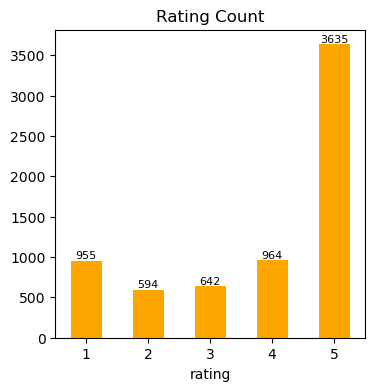

In [14]:
## Displays graphs directly within the notebook
%matplotlib inline 

ratings_count = filtered_df.groupby('rating').size()

ax = ratings_count.plot(kind = 'bar', figsize = (4,4), color = 'orange')

ax.tick_params(axis='x', rotation=0)

# Add labels above the bars
for i in ax.containers:
    ax.bar_label(i, fontsize=8)
    
ax.set_title('Rating Count');

#### How many reviews are there per year?

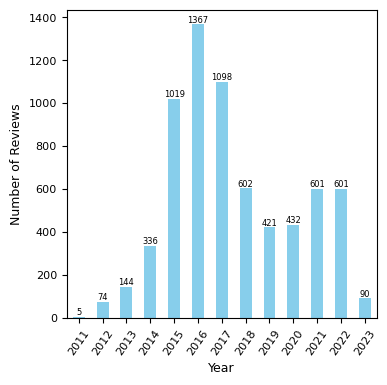

In [15]:
reviews_per_year = filtered_df.groupby('year').size()
ax = reviews_per_year.plot(kind = 'bar', figsize = (4,4), color = 'skyblue')
ax.tick_params(axis='x', rotation=55)
for i in ax.containers:
    ax.bar_label(i, fontsize=6)
ax.set_xlabel('Year', fontsize=9)
ax.set_ylabel('Number of Reviews', fontsize=9)
ax.tick_params(axis='both', labelsize=8)  # Set font size for y-axis ticks;


## Phrase Finder Using Gensim

### Preprocess text column

In [34]:
# Ensure all entries in the 'text' column are strings and fill NaN values with an empty string
filtered_df['text'] = filtered_df['text'].astype(str).fillna('')

# Tokenize function 
def sentence_tokenize(text):
    return sent_tokenize(text)

# Apply 
filtered_df['sentences'] = filtered_df['text'].apply(sentence_tokenize)
filtered_df[['text', 'sentences']].head(2)

,text,sentences
0,My wife absolutely loved her fitbit. It was ev...,"[My wife absolutely loved her fitbit., It was ..."
1,I wouldn't waste your time with this. I was p...,"[I wouldn't waste your time with this., I was ..."


In [37]:
def preprocess_sentence(sentence):
    # Tokenize text
    tokens = word_tokenize(sentence.lower())
    # Remove punctuation
    tokens = [word for word in tokens if word.isalnum()]
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

# Apply preprocessing to each sentence
filtered_df['preprocessed_sentences'] = filtered_df['sentences'].apply(lambda sentences: [preprocess_sentence(sentence) for sentence in sentences])

### Create bigrams

In [38]:
# Flatten the list of preprocessed sentences to fit the Phrases object
all_preprocessed_sentences = [sentence for sentences in filtered_df['preprocessed_sentences'] for sentence in sentences]

# Create bigrams
bigram_finder = Phrases(
    sentences=all_preprocessed_sentences,
    # min_count=25,
    connector_words=ENGLISH_CONNECTOR_WORDS
)

sorted(bigram_finder.find_phrases(all_preprocessed_sentences).items(), key = lambda x: -x[1])

[('gon_na', 5381.337662337663),
 ('bells_whistles', 4503.945652173913),
 ('stainless_steel', 3187.4076923076923),
 ('rose_gold', 2721.5960591133007),
 ('planned_obsolescence', 2656.173076923077),
 ('caller_id', 2645.4627016129034),
 ('blood_pressure', 2354.335227272727),
 ('buyer_beware', 2287.7184265010355),
 ('form_factor', 1895.778431372549),
 ('blue_tooth', 1569.5568181818182),
 ('special_edition', 1249.9638009049775),
 ('watching_tv', 1228.348814229249),
 ('pleasantly_surprised', 1227.7422222222222),
 ('stride_length', 1212.6007525083612),
 ('aria_scale', 1130.2864157119477),
 ('idle_alert', 1113.8790322580644),
 ('shopping_cart', 1018.0909090909091),
 ('deal_breaker', 954.7534562211982),
 ('finger_widths', 920.8066666666667),
 ('pushing_stroller', 856.8300248138959),
 ('personal_trainer', 799.0471074380165),
 ('usb_port', 770.7645089285714),
 ('class_action', 738.6149732620321),
 ('washing_dishes', 726.9526315789474),
 ('bike_rides', 724.2299625468165),
 ('trouble_shooting', 722.

### Create trigrams

In [41]:
trigram_finder = Phrases(
    sentences = bigram_finder[all_preprocessed_sentences],
    min_count = 5,
    connector_words = ENGLISH_CONNECTOR_WORDS
)

sorted(
    filter(
        lambda x: x[0].count('_') >= 2,   # Make sure that there are at least 3 words in the phrase
        trigram_finder.find_phrases(bigram_finder[all_preprocessed_sentences]).items()
    ),
    key = lambda x: -x[1]   # Sort by score
)

[('pushing_shopping_cart', 2615.517857142857),
 ('started_falling_apart', 1553.459090909091),
 ('resting_heart_rate', 1091.5249184909176),
 ('offered_25_discount', 861.5823529411765),
 ('monitors_heart_rate', 589.175382139984),
 ('contacted_customer_service', 513.9263157894737),
 ('called_customer_service', 508.57291666666663),
 ('tracks_sleep_patterns', 493.16161616161617),
 ('food_water_intake', 472.48064516129034),
 ('call_customer_service', 443.8454545454546),
 ('track_food_intake', 377.9845161290323),
 ('screen_scratches_easily', 342.6175438596491),
 ('trying_lose_weight', 318.9655923344948),
 ('many_calories_burned', 310.48012718600955),
 ('many_calories_burn', 239.91646191646194),
 ('worth_every_penny', 208.64529914529916),
 ('contact_customer_service', 203.42916666666667),
 ('couple_years_ago', 188.74871134020617),
 ('reminds_get_move', 184.93560606060606),
 ('would_recommend_anyone', 177.5381818181818),
 ('works_like_charm', 155.404774535809),
 ('seems_pretty_accurate', 103.10

## Text Vectorization with TF-IDF
Use TF-IDF vectorizer to transform the text into vectors based on the frequency of words in the text.

Consider single-word and two-word sequences that appear at least 50 times and find words that are similar to each other.

In [ ]:
# Remove null values in 'text' column 
filtered_df = filtered_df.dropna(subset=['text'])

In [ ]:
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(filtered_df['text'])
tfidf_matrix

## Topic Modeling

Unsupervised NLP technique used to discover hidden topics in text documents.

**Singular Value Decomposition (SVD)**: 
- Aka Latent Semantic Indexing (LSI).
- Reduces dimensionality to reveal latent structures.

**Non-Negative Matrix Factorization (NMF)**
- Decomposes the term-document matrix into:
    - W (Document-Topic Matrix): Distribution of topics across documents.
    - H (Term-Topic Matrix): Significance of terms across topics.
- Advantages:
    - Easier interpretation due to non-negative values.
    - Higher scores indicate stronger relevance.

In [ ]:
def display_topics(model, features, no_top_words=10):
    """
    Displays the top words for each topic in the given model.

    Parameters:
    model (sklearn.decomposition): The fitted topic model.
    features (list): The list of feature names (words) corresponding to the columns in the model's components_ attribute.
    no_top_words (int): The number of top words to display for each topic. Default is 5.
    """
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([features[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

### SVD (Singular Value Decomposition)

In [ ]:
indices = filtered_df.index
for idx in indices:
    # Fit SVD on the current review and display its topics
    svd_pipe = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('svd', TruncatedSVD(n_components=5))
    ])
    
    # Fit the pipeline on the current review's text
    svd_pipe.fit([filtered_df['text'][idx]])
    
    # Get vocabulary and components
    svd_vocab = svd_pipe.named_steps['tfidf'].get_feature_names_out()
    svd_components = svd_pipe.named_steps['svd'].components_
    
    # Display topics for the current review
    display_topics(svd_pipe.named_steps['svd'], svd_vocab)

In [ ]:
svd_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svd', TruncatedSVD(n_components = 7))
])

svd_pipe.fit(reviews_subset['text'])
svd_vocab = svd_pipe.named_steps['tfidf'].get_feature_names_out()
svd_omponents = svd_pipe.named_steps['svd'].components_

In [ ]:
topic_num = 0

pd.DataFrame({
    'word': svd_vocab,
    'weight': svd_omponents[topic_num]
}).sort_values('weight', ascending = False).head(10)

In [ ]:
display_topics(svd_pipe.named_steps['svd'], svd_vocab)

In [ ]:
plt.figure()
wordcloud(reviews_subset['text'], max_words = 100)

### NMF (Non-negative Matrix Factorization)

In [ ]:
nmf_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nmf', NMF(n_components = 7))
])

nmf_pipe.fit(reviews_subset['text'])

nmf_vocab = nmf_pipe.named_steps['tfidf'].get_feature_names_out()
nmf_components = nmf_pipe.named_steps['nmf'].components_

In [ ]:
topic_num = 3

pd.DataFrame({
    'word': nmf_vocab,
    'weight': nmf_components[topic_num]
}).sort_values('weight', ascending = False).head(10)

In [ ]:
display_topics(nmf_pipe.named_steps['nmf'], nmf_vocab)

### Word Clouds

In [ ]:
# SVD
wordcloud_topics(svd_pipe, svd_vocab)

# NMF
wordcloud_topics(nmf_pipe, nmf_vocab)

## Text Summarization

### Using TF-IDF 

Indentifying important words with TF-IDF values

In [ ]:
# Parameter to specify number of summary sentences 
num_summary_sentence = 4

# Sort the sentences in descending order by the sum of TF-IDF values 
sent_sum = tfidf_text.sum(axis = 1)
important_sent = np.argsort(sent_sum, axis = 0)[::-1]

# Print three most import sentences in the order they appear in the article 
for i in range(0, len(sentences)):
    if i in important_sent[:num_summary_sentence]:
        print (sentences[i])

In [ ]:
def summarize_with_tfidf(doc, num_summary_sentence = num_summary_sentence)
    """
    Apply the TF-IDF vectorization and then aggregate the value to a sentence level.
    Generate a score for each sentence as a sum of the TF-IDF values for each word in that sentence. 
    A sentence with a high score contains many important words as compared to other sentences in the column.
    """

    # Tokenize the text into sentences 
    sentences = []
    for text in doc:
        sentences.extend(sent_tokenize(text))

    # Compute TF-IDF for the sentences 
    tfidf = TfidfVectorizer()
    tfidf_text = tfidf.fit_transform(sentences)
    
    # Sort the sentences in descending order by the sum of TF-IDF values 
    sent_sum = tfidf_text.sum(axis = 1)
    important_sent = np.argsort(sent_sum, axis = 0)[::-1].flatten()
    
    # Collect the most important sentences 
    summary_sentences = [sentences[i] for i in important_sent[:num_summary_sentence]]

    return summary_sentences

In [ ]:
num_summary_sentence = 4
summarize_with_tfidf(filtered_df['text'])

### Using LSA 
Latent semantic analysis (LSA) assumes that words that are close in meaning will occur in the same documents. Use package sumy to provide multiple summarization methods. 

In [ ]:
LANGUAGE = 'english'
stemmer = Stemmer(LANGUAGE)

parser = PlaintextParser.from_string(filtered_df['text'], Tokenizer(LANGUAGE))
summarizer = LsaSummarizer(stemmer)
summarizer.stop_words = get_stop_words(LANGUAGE)

for sentence in summarizer(parser.document, num_summary_sentence):
    print (str(sentence))

In [ ]:
summary_sentence = tfidf_summary = 